## **Histopathic Cancer Detection using CNN model**

### We are lucky to live in a time where technological technology enables the medical industry to provide better patient care. Because so many individuals develop cancer and/or pass away from it, the disease is a subject of intense investigation. By utilizing computer vision and machine learning techniques, this study seeks to improve the identification of cancer in lymph nodes. To better comprehend the information provided in this competition, we shall investigate it.After that, we'll test a number of convolutional neural network models with the goal of being able to distinguish between cancerous and non-cancerous cells (0). Patients will be able to receive life-saving treatments more quickly thanks to improved and quicker cancer detection. This represents the beginning of their cancer survival story. The method for developing straightforward CNN models is covered in this notebook. Two models, one with and one without hyperparameter adjustment, will be built. We will make some recommendations on ways to make the models better in next research.

Layout for this notebook is as follows: 


1. A Short Description of the Issue and Information
2. Examine, Visualize, and Clean the Data Using Exploratory Data Analysis (EDA)
3. Explanation of Model Architecture
4. Findings and Evaluation

In [1]:
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## importing libraries for Model Development

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

## libraries To process images

In [ ]:
from skimage.transform import rotate
from skimage import io
import cv2 as cv

## libraries to process images

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

In [2]:
# Get files
test_path = '../data/histopathologic-cancer-detection/test/'
train_path = '../data/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../data/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../data/histopathologic-cancer-detection/train_labels.csv')

# 1. Brief Description of the Problem and Data

* The dataset contains the histopathological Images, each image is 96px * 96px with 3 channels. 
* We have two datasets, a training and testing set already split for us.
* The training set contains 220,025 unique images and the test set contains about 57,500.
* To use these images in a machine learning model, we are also given an identifying dataframe with two columns: 'id' which is the unique image ID correpsonding to the training directory, and 'label' which tells us the classification category.
* Each label is either a 0 or 1, depending whether the image is non-cancerous (0) or cancerous (1). 
* In the competition description, we find that if at least one pixel of an image is identified as cancerous then the whole image is therefore marked with a 1, otherwise it is 0. It is important to note that we do not have any missing values in this data which will make preprocessing more efficient.

In [3]:
# constant declaration for reproduciblity
RANDOM_STATE = 49

In [4]:
# peek into the data
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
# peek into the folder in the training dataset?

print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [6]:
train_data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
# analysing the data for information, data types, and for missing data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


# 2. (EDA) - Visualize and Clean the Data

After we visualize the data we will perform cleaning on the data 

* The histogram and pie chart reveal that 59.5% of the images are labeled 0 (non-cancerous) and 40.5% are labeled 1 (cancerous).
* Although the competition description stated that the data would be evenly split between the two categories, our data is actually closer to a 40/60 split.
* While this does mean that the data is unbalanced, it is not severely unbalanced like a split of 30/70 or 10/90. 
* With thousands of images available for training, it is reasonable to assume that we can create a model that accurately identifies cancerous images.

   Label Counts
0        130908
1         89117


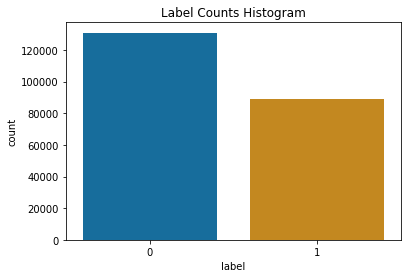

In [8]:
# creating histogram for label counts

print(pd.DataFrame(data={'Label Counts': train_data['label'].value_counts()}))
sns.countplot(x=train_data['label'], palette='colorblind').set(title='Label Counts Histogram');

### Below are a few examples of photos from the practice data. We have created a box around this region to serve as the image's focal point because we were told that each 32x32 pixel image has the (possibly malignant) cells in its center.

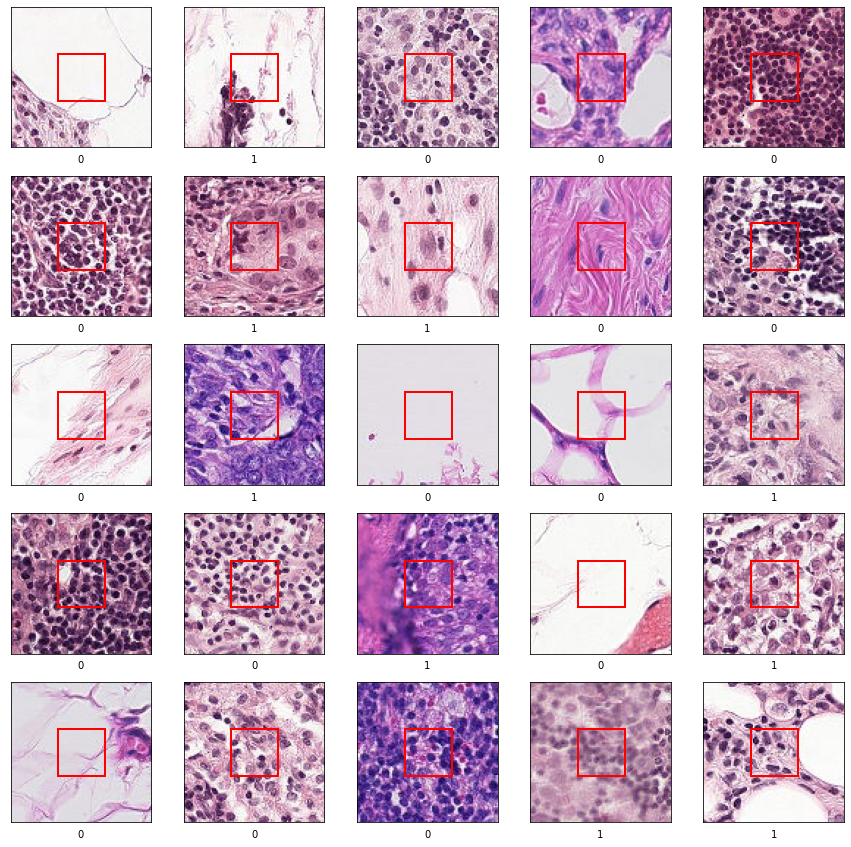

In [10]:
# to visualize some images

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    axis.imshow(io.imread(train_path + train_data.id[i] + '.tif'))
    axis.add_patch(patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r', facecolor='none', linestyle='-'))
    axis.set(xticks=[], yticks=[], xlabel=train_data.label[i])

# 3. Description of Model Architecture 

**Model:**
1. Scale the images before training by dividing each image pixel value by 255.
2. Use the sigmoid function as the activation for the final layer.
3. Employ the Adam optimization algorithm.
4. Set the learning rate to 0.0001.
5. Use the ReLU activation function for all hidden layers.
6. Implement a dropout rate of 0.3 to prevent overfitting.

In [11]:
# setting constants for the model

BATCH_SIZE = 256

In [12]:
# preparation of training phase of data
def append_tif(string):
    return string + ".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data["label"] = train_data["label"].astype(str)
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [13]:
# Transform the training data by scaling its values and divide it into two parts - one for training and another for validation.

datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [14]:
# training phase 
train_data_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))        # original image = (96, 96) 

Found 187022 validated image filenames belonging to 2 classes.


In [15]:
# generate validation data
valid_data_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))       # original image = (96, 96) 

Found 33003 validated image filenames belonging to 2 classes.


In [16]:
# Configure the GPU accelerator strategy and set it to TPU if available, otherwise use GPU or CPU as default.
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

### The model has been taken from <a href = 'https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb'>Baseline Keras CNN</a>

In [20]:
# set ROC AUC as metric

ROC_1 = tf.keras.metrics.AUC()

# use GPU
with strategy.scope():kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (64, 64, 3))) # original image = (96, 96, 3) 
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 64)       

In [21]:
#compilation phase 
adam_optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1], optimizer=adam_optimizer)

In [22]:
EPOCHS = 20

# training the model
trained_model = model.fit(
                        train_data_generator,
                        epochs = EPOCHS,
                        validation_data = valid_data_generator)

Epoch 1/20
731/731 [==============================] - 809s 1s/step - loss: 0.4909 - accuracy: 0.7645 - auc_1: 0.8351 - val_loss: 0.4517 - val_accuracy: 0.7890 - val_auc_1: 0.8665
Epoch 2/20
731/731 [==============================] - 337s 462ms/step - loss: 0.4294 - accuracy: 0.8072 - auc_1: 0.8768 - val_loss: 0.4074 - val_accuracy: 0.8244 - val_auc_1: 0.9029
Epoch 3/20
731/731 [==============================] - 296s 405ms/step - loss: 0.3789 - accuracy: 0.8354 - auc_1: 0.9057 - val_loss: 0.4171 - val_accuracy: 0.8082 - val_auc_1: 0.9177
Epoch 4/20
731/731 [==============================] - 303s 414ms/step - loss: 0.3551 - accuracy: 0.8461 - auc_1: 0.9178 - val_loss: 0.4482 - val_accuracy: 0.7977 - val_auc_1: 0.9116
Epoch 5/20
731/731 [==============================] - 302s 413ms/step - loss: 0.3434 - accuracy: 0.8516 - auc_1: 0.9233 - val_loss: 0.4513 - val_accuracy: 0.7956 - val_auc_1: 0.9189
Epoch 6/20
731/731 [==============================] - 294s 403ms/step - loss: 0.3359 - accura

In [23]:
# to use evaluate_generator getting the metric names
model.metrics_names

['loss', 'accuracy', 'auc_1']

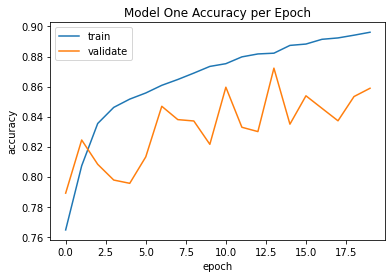

In [24]:
# accuracy of plot_model vs. epoch
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

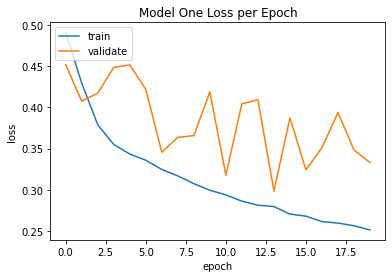

In [25]:
# plot model loss vs. epoch
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

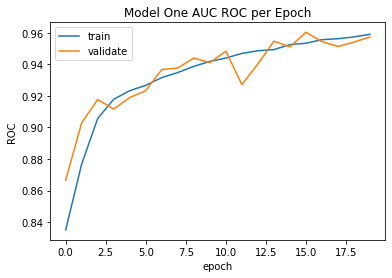

In [27]:
# plot model ROC per epoch
plt.plot(trained_model.history['auc_1'])
plt.plot(trained_model.history['val_auc_1'])
plt.title('Model One AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

**Testing the final model against test set**

### Now that the model is trained, we can evaluate it on previously unseen test data images by normalizing them in the same way as the training data.

In [28]:
#double check what you're aiming the submission data set to look like
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [29]:
#creating the dataframe for predictions
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [45]:
# preparing the test data
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    test_df,
    test_path,
    x_col='id',
    target_size=(64,64),
    batch_size=1,
    class_mode=None)

Found 57458 validated image filenames.


In [46]:
#finding the predictions by running the model

# model_predictions = model.predict(test_generator, verbose=1)
model_predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 171s 3ms/step


In [47]:
len(model_predictions)

57458

In [48]:
#constructing dataframe for submission
model_predictions = np.transpose(predictions)[0]
df_submission = pd.DataFrame()
df_submission['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
df_submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
df_submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [49]:
# taking a look at count of prediction
df_submission['label'].value_counts()

0    30362
1    27096
Name: label, dtype: int64

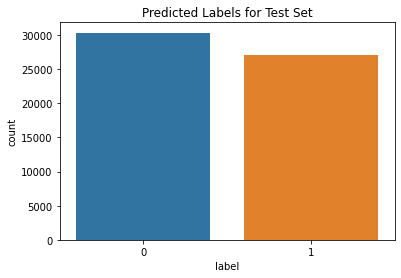

In [50]:
#plotting the predictions on graph
sns.countplot(data=df_submission, x='label').set(title='Predicted Labels for Test Set');

In [51]:
#converting the df to csv for futhur use
df_submission.to_csv('submission.csv', index=False)

# 4. Results after the Analysis

"We evaluated the performance of the models by analyzing their accuracy, loss and ROC metrics on the training and validation datasets. The results showed that the complex model performed better than the simple model in terms of ROC metric. However, the accuracy and loss of the complex model were not stable. This could be due to insufficient training epochs (only 20). A more complex CNN model with a large number of images might require more training time to converge.

Finally, the performance of the trained model was evaluated on the test dataset, and the results are shown below."